In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/tm_evaluation/evaluation

/content/drive/MyDrive/tm_evaluation/evaluation


In [33]:
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.svm import  SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import umap
import hdbscan
import re
import nltk

In [3]:
import pandas as pd
df= pd.read_csv("/content/drive/MyDrive/tm_evaluation/twitter-financial-news-topic.csv")
df.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


In [4]:
df.shape

(16990, 2)

In [5]:
df['label'].unique()

array([ 0,  2,  9,  8,  4,  5,  6,  1,  7, 10, 11, 12, 13, 14, 15, 17, 16,
       18, 19,  3])

In [6]:
dataset = df.copy()

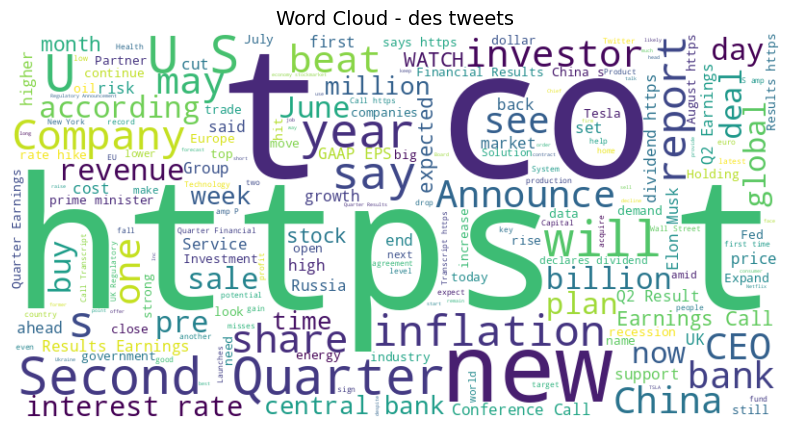

In [7]:
# Fonction pour générer le word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

# Générer le word cloud
generer_wordcloud(df['text'], 'Word Cloud - des tweets')

In [ ]:
!pip install  octis
!pip install sentence-transformers
!pip install bertopic

In [ ]:

# Étape 1 : Charger et préparer les données
#data = fetch_20newsgroups(subset='all')['data']
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
def preprocess_data(text):

  tokens = word_tokenize(text)
  stop_words = set(stopwords.words("english"))
  tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation des tokens
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joindre les tokens en une seule chaîne
  cleaned_text = ' '.join(tokens)

  return cleaned_text

data = dataset.copy()
data.text = data.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
data.text = data.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
data.text = data.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
data['text'] = data.text.apply(preprocess_data)

In [28]:

embedding_model = SentenceTransformer('all-MiniLM-L12-v2')
umap_model = umap.UMAP(n_neighbors=15, n_components=10, min_dist=0.1, random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
topic_model_mini = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)

topics_mini, probs = topic_model_mini.fit_transform(data.text)

df = pd.DataFrame({"Document": data.text, "Topic": topics_mini})

df = df[df['Topic'] != -1]

X_train, X_test, y_train, y_test = train_test_split(df['Document'], df['Topic'], test_size=0.2, random_state=42)

X_train_embeddings = embedding_model.encode(X_train.tolist(), convert_to_tensor=True)
X_test_embeddings = embedding_model.encode(X_test.tolist(), convert_to_tensor=True)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [29]:
topic_model_mini.get_topic(0)[:10]

[('rate', 0.03072163815285285),
 ('inflation', 0.030641385634082863),
 ('fed', 0.030162012379178153),
 ('hike', 0.026930259959903276),
 ('ecb', 0.022307556039587038),
 ('interest', 0.019061619679044853),
 ('point', 0.017632709554953878),
 ('central', 0.016189065464123516),
 ('basis', 0.016017682818805674),
 ('recession', 0.014839935705924174)]

In [31]:
topic_model_mini.visualize_topics()

In [34]:
dict_of_models = {
        "Extra Trees": ExtraTreesClassifier(n_jobs=-1),
        "Random Forest": RandomForestClassifier(n_jobs=-1),
        "Logistic Regression": make_pipeline( StandardScaler(),LogisticRegression()),
        "SVM": make_pipeline( StandardScaler(), SVC(random_state=42)),
        "K-Nearest Neighbors": make_pipeline( StandardScaler(),KNeighborsClassifier()),
        "AdaBoost":AdaBoostClassifier(),
        "XGboost": XGBClassifier(),
        #"Gradient Boosting": GradientBoostingClassifier(),
        "Decision Tree": DecisionTreeClassifier()

}

In [35]:
def evaluation(model,name_model, X_train, y_train, X_test, y_test):

    start_time = time.time()
    model.fit(X_train.cpu().numpy(), y_train)

    end_time = time.time()
    training_time = end_time - start_time

    y_pred = model.predict(X_test.cpu().numpy())
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred,average='macro')
    recall = recall_score(y_test, y_pred,average='macro')

    # Creation of dictionaries containing metrics
    more_metrics_dict = {
        'Accuracy': accuracy,
        'f1_score': f1score,
        'Precision': precision,
        'Recall': recall,
        'Training Time': training_time
    }


    return more_metrics_dict

In [36]:
def visualize_metric_results(df_results, metric):
    # Sort DataFrame by the specified metric
    sorted_df = df_results.sort_values(by=metric, ascending=False)

    # Use a color palette from plotly express for different models
    colors = px.colors.qualitative.Plotly[:len(sorted_df)]
    # Create the plot
    fig = px.bar(sorted_df, x=sorted_df.index, y=metric, color=sorted_df.index, color_discrete_sequence=colors)

    # Update layout
    fig.update_layout(
        title=f'Results sorted by {metric}',
        xaxis_title='Model',
        yaxis_title=metric
    )

    fig.show()

In [37]:
import time

results = {}

for name_model, model in dict_of_models.items():
    results[name_model]  = evaluation(model,name_model, X_train_embeddings, y_train, X_test_embeddings, y_test)
    print("\n")

df_results = pd.DataFrame(results).T
display(df_results.sort_values(by='f1_score', ascending=False))

# Test de la fonction avec 'Accuracy'
visualize_metric_results(df_results, 'f1_score')

,Accuracy,f1_score,Precision,Recall,Training Time
K-Nearest Neighbors,0.953305,0.926621,0.948408,0.922098,0.040395
Logistic Regression,0.930745,0.901028,0.923818,0.895808,9.959983
SVM,0.926023,0.895374,0.944976,0.871404,13.272749
XGboost,0.763903,0.708102,0.758925,0.698449,59.421741
Extra Trees,0.749738,0.674268,0.857387,0.599846,1.171499
Random Forest,0.738195,0.641304,0.831696,0.569454,7.175163
Decision Tree,0.416579,0.309582,0.325471,0.326887,25.577387
AdaBoost,0.096013,0.018079,0.021242,0.025092,53.225694


In [ ]:
data = dataset.copy()

In [39]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from bertopic import BERTopic


# Convertir les textes en TaggedDocument
tagged_data = [TaggedDocument(words=row['text'], tags=[str(i)])
               for i, row in data.iterrows()]

# Entraîner le modèle Doc2Vec
doc2vec_model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, epochs=100, total_examples=doc2vec_model.corpus_count)

# Fonction pour obtenir les embeddings Doc2Vec
def encode_doc2vec(sentences):
    return [doc2vec_model.infer_vector(sentence) for sentence in sentences]

# Créer le modèle BERTopic avec les embeddings Doc2Vec
topic_model_doc2vec = BERTopic(embedding_model=encode_doc2vec)

# Exemple d'utilisation avec les textes
texts = data['text'].tolist()
topics_doc2vec, probs = topic_model_doc2vec.fit_transform(texts)



In [40]:

df = pd.DataFrame({"Document": data.text, "Topic": topics_doc2vec})

df = df[df['Topic'] != -1]

X_train, X_test, y_train, y_test = train_test_split(df['Document'], df['Topic'], test_size=0.2, random_state=42)

X_train_embeddings = embedding_model.encode(X_train.tolist(), convert_to_tensor=True)
X_test_embeddings = embedding_model.encode(X_test.tolist(), convert_to_tensor=True)
import time

results = {}

for name_model, model in dict_of_models.items():
    results[name_model]  = evaluation(model,name_model, X_train_embeddings, y_train, X_test_embeddings, y_test)
    print("\n")

df_results = pd.DataFrame(results).T
display(df_results.sort_values(by='f1_score', ascending=False))

# Test de la fonction avec 'Accuracy'
visualize_metric_results(df_results, 'f1_score')

,Accuracy,f1_score,Precision,Recall,Training Time
Logistic Regression,0.893637,0.854494,0.879747,0.852648,18.859127
SVM,0.858337,0.812438,0.880489,0.794134,20.247907
K-Nearest Neighbors,0.850906,0.804784,0.834284,0.809922,0.045424
XGboost,0.698096,0.636366,0.690877,0.637391,105.533357
Extra Trees,0.676730,0.602420,0.757164,0.555870,1.773454
Random Forest,0.670228,0.590208,0.732730,0.547812,19.504095
Decision Tree,0.347422,0.303176,0.321730,0.327521,79.572911
AdaBoost,0.045053,0.008031,0.008929,0.010882,95.373237


In [ ]:

use_model = SentenceTransformer('all-MPNet-base-v2')

def encode_use(sentences):
    return use_model.encode(sentences)

topic_model_use = BERTopic(embedding_model=encode_use)


texts = data['text'].tolist()
topics_use, probs = topic_model_use.fit_transform(texts)



In [43]:
df = pd.DataFrame({"Document": data.text, "Topic": topics_use})

df = df[df['Topic'] != -1]

X_train, X_test, y_train, y_test = train_test_split(df['Document'], df['Topic'], test_size=0.2, random_state=42)

X_train_embeddings = embedding_model.encode(X_train.tolist(), convert_to_tensor=True)
X_test_embeddings = embedding_model.encode(X_test.tolist(), convert_to_tensor=True)
import time

results = {}

for name_model, model in dict_of_models.items():
    results[name_model]  = evaluation(model,name_model, X_train_embeddings, y_train, X_test_embeddings, y_test)
    print("\n")

df_results = pd.DataFrame(results).T
display(df_results.sort_values(by='f1_score', ascending=False))

# Test de la fonction avec 'Accuracy'
visualize_metric_results(df_results, 'f1_score')

,Accuracy,f1_score,Precision,Recall,Training Time
Logistic Regression,0.888941,0.867859,0.900317,0.867955,15.751890
K-Nearest Neighbors,0.861531,0.813158,0.848263,0.818569,0.044966
SVM,0.858223,0.804640,0.890020,0.774564,19.589337
XGboost,0.705577,0.646909,0.706325,0.649455,106.241082
Extra Trees,0.687618,0.621574,0.784283,0.566313,1.971371
Random Forest,0.684783,0.602598,0.738395,0.558700,19.452615
Decision Tree,0.352079,0.277250,0.288249,0.303320,74.170596
AdaBoost,0.034499,0.003428,0.003126,0.006897,93.458564
